## A. The goal of this part is to implement the Huffman coding and how it can be enhanced to reach the optimal bound.

In [6]:
from __future__ import division
import numpy as np
import scipy as sp
import pylab as pl
import scipy.signal as sg
import matplotlib.pyplot as plt

### The definition of the entropy: Given a probability vector on a finite space $\Omega = \{\omega_1,\ldots,\omega_n\}$ denoted by $p = (p_1,\ldots,p_n)$. The entropy is the quantity defined by $H(p) = -\sum_{i = 1}^n p_i \log(p_i)$. It's a concave function which is positive since $p_i \in [0,1]$ and thus $\log(p_i) \geq 0$.

In [7]:
def ShannonEntropy(p):
    return -np.sum(p*np.log2(np.maximum(p,1e-15)))

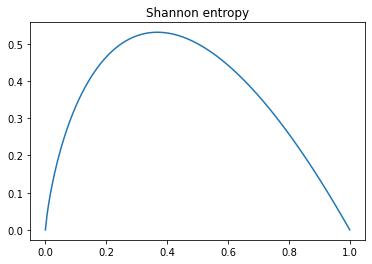

In [8]:
n = 200
x = np.linspace(1e-10,1,n)
plt.title("Shannon entropy")
plt.plot(x,-x*np.log2(x))

## In what follows, we consider that the $\omega_i$ are letters of some alphabet which have a frequency of appearance of $p_i$.

In [9]:
## Generate a random text according to the frequencies.
n = 512; p = 0.3
x = (np.random.rand(n) > p) + 1
h = [np.sum(x == 1), np.sum(x == 2)]
h = h/np.sum(h)
print(h)
print("Empirical p = %.2f" %h[0])

[0.3046875 0.6953125]
Empirical p = 0.30


In [10]:
e = ShannonEntropy(h)
print("Entropy = %.2f" %e)

Entropy = 0.89


In [11]:
### Definition of the probability h
h = [.1, .15, .4, .15, .2]
print(ShannonEntropy(h))

2.1464393446710153


### We use a python library to represent a binary tree. We assume that the tree is coded in the following way, here is an example, $(a,((b,c),(d,e))$.

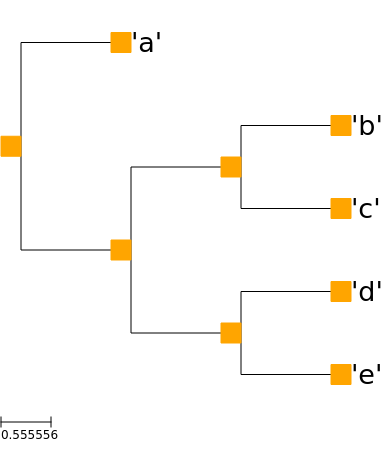

In [40]:
## import ete3 using if you have conda: 
## conda install -c etetoolkit ete3
## otherwise try: pip install ete3
from ete3 import Tree, TreeNode, TreeStyle , NodeStyle, AttrFace, faces
## Define the tree
T = ("a",(("b","c"),("d","e")))

t = Tree(str(T)+";")


ts = TreeStyle()
#ts.rotation = 90
ts.scale = 90
ts.branch_vertical_margin = 50 # 10 pixels between adjacent branches
ts.show_leaf_name = False #

nstyle = NodeStyle()
nstyle["shape"] = "square"
nstyle["size"] = 20
nstyle["fgcolor"] = "orange"

for n in t.traverse():
    n.set_style(nstyle)

for node in t.iter_leaves():
    node.add_face(AttrFace("name", fsize=20), column=0)  
    
t.render("%%inline", tree_style = ts)

### Q1. Write a function that generates the Huffman tree with the probability $h$ as input. Plot the tree with the function above. 

In [43]:
key_prob = "prob"
key_code = "code"

def GetDuffman(h, values):
   
    # Ts is a list of nodes
    # We will index probability with dist
    ts = [TreeNode()] * len(h)
    for i in range(len(h)):
        t = TreeNode(name = values[i])
        t.add_feature(key_prob, h[i]) # set probability
        ts[i] = t
    while len(ts) > 1:
        n = len(ts) 
        # in place
        ts.sort(reverse=True, key=lambda node : getattr(node, key_prob))
        penul = ts[n-2]
        ul    = ts[n-1]
        # add attributes of path (either 0, or 1)
        penul.add_feature(key_code, 1)
        ul.add_feature(key_code, 0)
        node = TreeNode()
        # cumulative probability
        node.add_feature(
            key_prob, getattr(penul, key_prob) 
            + getattr(ul, key_prob)
        )
        node.add_child(penul)
        node.add_child(ul)
        ts[n-2] = node
        ts.pop()
    t = ts[0]
    return t



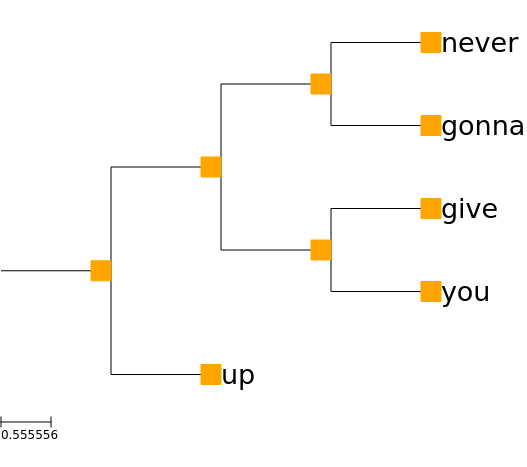

In [59]:
h   = [.1, .15, .4, .15, .2]
values = ["you", "gonna", "up", "give","never"]

t = GetDuffman(h, values)

ts = TreeStyle()
#ts.rotation = 90
ts.scale = 90
ts.branch_vertical_margin = 50 # 10 pixels between adjacent branches
ts.show_leaf_name = False #

nstyle = NodeStyle()
nstyle["shape"] = "square"
nstyle["size"] = 20
nstyle["fgcolor"] = "orange"
for n in t.traverse():
    n.set_style(nstyle)

for node in t.iter_leaves():
    node.add_face(AttrFace("name", fsize=20), column=0)

t.render("%%inline", tree_style = ts) 


### Q2. Write the function HuffmanGencode which computes the Huffman code of an element in $0,1,2,3,4$  and prints it.

In [45]:
def ParseBin(s):
    # reverse the string
    s = s[::-1]
    # parse from binary (base 2)
    return bin(int(s, 2))

def GetCodeLeaf(leaf):
    parent = leaf
    code = ""
    while (not (parent == None or parent.is_root())):
        code += str(getattr(parent, key_code))
        parent = parent.up
    code = ParseBin(code)
    return code

def HuffmanGencode(t, elements):
    codes = {}  ## dictionnary the key is a number and 
                ## the value is the code in 0,1.
    for leaf in t.iter_leaves():
        # key_value -> element
        codes[leaf.name] = GetCodeLeaf(leaf)
    return codes    

In [53]:
h   = [.1, .15, .4, .15, .2]
values = np.arange(5)

t = GetDuffman(h, values)

codes = HuffmanGencode(t, values)
print(codes)

{4: '0b111', 1: '0b110', 3: '0b101', 0: '0b100', 2: '0b0'}


### Q3. Write a function that generates a random sequence of numbers between $0$ and $4$ according to the probability $h$.

In [96]:
def RandGen(p, number, lowest, largest):
    # binomial distribution of number elements in [lowest, largest]
    # with parameter p
    b = np.random.binomial(largest - lowest, p, number)
    return  b + np.full_like(b, lowest)

In [97]:
p = .4
x = RandGen(p, 512, 0, 4)
print(x)

[2 2 3 2 2 2 3 3 2 2 3 1 1 1 2 2 3 1 1 1 1 1 1 0 1 0 3 0 2 3 2 1 3 2 2 3 1
 2 0 3 1 2 4 1 0 1 1 2 2 2 1 3 2 0 0 1 2 2 0 2 1 0 3 1 1 3 2 1 1 4 0 2 1 0
 1 1 2 0 1 3 2 0 2 1 1 0 2 0 1 2 1 2 1 3 2 2 1 1 3 1 2 0 1 2 2 1 2 0 3 1 2
 1 2 2 1 2 0 0 2 2 0 1 2 2 3 0 1 0 1 1 1 2 2 3 1 2 3 0 1 1 1 3 3 2 0 1 2 3
 1 2 2 1 2 3 0 2 1 0 1 1 4 3 1 0 0 0 2 3 1 2 1 2 2 2 0 2 0 2 2 1 1 4 2 1 3
 3 3 1 2 1 2 2 0 1 2 4 1 1 1 4 0 2 3 1 2 3 0 2 3 0 2 2 1 2 1 0 2 2 1 1 3 2
 2 3 1 3 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 0 4 2 3 0 1 1 2 1 0 1 2 2 1 3 2 1 2
 2 1 1 3 1 2 1 1 3 1 4 1 2 3 2 2 1 3 1 1 2 1 2 1 4 2 0 1 2 2 2 1 1 0 1 1 2
 1 1 2 1 2 2 2 1 1 1 2 2 2 2 2 1 3 1 2 0 1 1 2 3 1 2 2 2 1 1 2 1 3 1 0 1 1
 3 2 1 2 2 2 1 1 1 0 2 1 1 3 1 0 3 2 0 0 4 1 2 1 3 1 1 1 0 2 3 0 2 4 4 1 3
 0 1 1 1 1 1 0 0 0 0 2 2 3 3 3 2 1 1 2 2 1 2 2 1 2 1 1 2 0 2 1 2 4 2 2 1 2
 1 2 1 2 2 1 0 1 1 3 1 1 3 2 2 1 1 0 1 1 3 1 3 2 2 2 3 2 3 3 4 1 3 0 4 3 0
 2 2 2 2 2 1 2 2 2 2 3 0 2 0 2 1 1 3 2 2 3 1 0 0 3 2 0 2 2 3 1 2 2 1 0 2 3
 3 3 1 3 3 2 1 2 1 3 2 2 

In [98]:
def GetValuesAndProbabilities(x):
    # values -> x without duplicate
    values = list(dict.fromkeys(x))
    h = [
        x.count(val) / len(x) 
        for val in x
    ]
    return h, values

def BinToString(b):
    return 

### Q4. Write a function which maps a random sequence as above into its Huffman code and test it.

In [99]:
def CodeHuffman(x,codes):
    result = ""
    for val in x:
        # remove to 0b that signifies it's a binary number
        result += str(codes[val]).replace("Ob")
    return result

In [100]:
code = CodeHuffman(x,codes)
print(code)

0b00b00b1010b00b00b00b1010b1010b00b00b1010b1100b1100b1100b00b00b1010b1100b1100b1100b1100b1100b1100b1000b1100b1000b1010b1000b00b1010b00b1100b1010b00b00b1010b1100b00b1000b1010b1100b00b1110b1100b1000b1100b1100b00b00b00b1100b1010b00b1000b1000b1100b00b00b1000b00b1100b1000b1010b1100b1100b1010b00b1100b1100b1110b1000b00b1100b1000b1100b1100b00b1000b1100b1010b00b1000b00b1100b1100b1000b00b1000b1100b00b1100b00b1100b1010b00b00b1100b1100b1010b1100b00b1000b1100b00b00b1100b00b1000b1010b1100b00b1100b00b00b1100b00b1000b1000b00b00b1000b1100b00b00b1010b1000b1100b1000b1100b1100b1100b00b00b1010b1100b00b1010b1000b1100b1100b1100b1010b1010b00b1000b1100b00b1010b1100b00b00b1100b00b1010b1000b00b1100b1000b1100b1100b1110b1010b1100b1000b1000b1000b00b1010b1100b00b1100b00b00b00b1000b00b1000b00b00b1100b1100b1110b00b1100b1010b1010b1010b1100b00b1100b00b00b1000b1100b00b1110b1100b1100b1100b1110b1000b00b1010b1100b00b1010b1000b00b1010b1000b00b00b1100b00b1100b1000b00b00b1100b1100b1010b00b00b1010b1100b1010b1100b00b1100b1100b11

### Q5. Compare with the Shannon bound.
### Q6. Write below a function that decodes the Huffman code and test it on a random sequence. Check that it is the inverse of the coding map.

In [ ]:
def DecodeHuffman(code,T):
    result = []
    return np.asarray(result)

## Block Huffman coding to reach better performances. 
### We consider a probability as below on an alphabet of two letters $a,b$.

### Q7: Compute the entropy associated with this probability and generalize for an alphabet described by blocks of $k$ letters.

In [ ]:
t = .12
h = [t, 1-t]
n = 20000
x = (np.random.rand(n) > t) + 1

### Q7bis. Compare the length of the Huffman code and the Shannon bound. How to explain the difference ? In order to improve the result, we use Huffman coding on blocks of length $k$. 

### Q8. Write a code that takes as input a sequence of length $k$ of letters and associate a binary code. Then, write a function that takes as inputs a random sequence its code by block of length $k$. We assume that the length is a multiple of $k$.

In [ ]:
def CodeBlocks(x):
    return 0
def GenNewCode(x):
    return 0

### Q9. Write a function that gives the empirical probability of the message encoded by $k$-blocks.

In [ ]:
def EstimateProbabilites(code,taille_blocs):
    return 0

### Q10. Given a random sequence generated from the probability $h$, plot the performance of the Huffman code (length of the code - Shannon bound) in terms of $k$ the block length. Comment.

# B. The goal of this part is to explore implementations of a FIR or an IIR.

## Q1. Implement an ideal low pass filter using Fourier transform in 1D:
### Compute the inverse FFT of a low pass filter and cut it with a window that will be passed in argument. 

## Q2. Implement an IIR filter defined by its numerator which will be set to a  constant $b$ and its denominator which will be set to $1-az^{-1}$. 
### What can you say about the range of the parameter $a$ in order to obtain a stable filter. 
### Experimentally, determine the ranges of $a$ to get respectively a low-pass filter and a high-pass filter. Give a theoretical explanation.

## In the following, we are given an electrocardiogram. We plot it as a function of time and we 

In [ ]:
### load the data which is an electrocardiogram which is sampled at 360Hz
ecg = sp.misc.electrocardiogram()
### Different plots.
fs = 360.0
### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 10.2)
plt.ylim(-1, 1.5)
plt.show()
print("time min", time[0])
print("time max", time[-1])

In [ ]:
### Use the scipy function to get the power spectrum of the signal.
f, Pxx = sg.welch(ecg, fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

### Q3. Estimate the number of heartbeats in the following electrocardiogram and estimate the mean value of the interval between two heartbeats. You can use the method of your choice. A possible method consists in using a band pass filter and then extract the maximum values of the filtered signal.